## Define Imports and Determine Device

In [2]:
#!/usr/bin/env python
# coding: utf-8

# ## Define Imports and Determine Device
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
os.sys.path.insert(0, "source")
from DiabetesData import DiabeticData
from Autoencoder import ConvAutoencoder
from ConvVarAutoencoder import ConvVAE
from DogCatData import DogCatData
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
datatype="dogcat"
batch_size=16
epochs = 0
model_file = "models/ConvAE_task_25.pth"
normalize=False
size=100

cuda


# read in data

In [5]:
if datatype == "diabetes":
    filename = "data/trainLabels_ad.csv"
    root_dir = "data/diabetes_resized"
    task = ([0],[4])
    # task = ([0,1,2], [3,4])
    # task = ([0,1,2], (3,4))

    train = pd.read_csv("data/diabetes_ad_train.csv")
    val = pd.read_csv("data/diabetes_ad_valid.csv")
    test = pd.read_csv("data/diabetes_ad_test.csv")

    data = {'train': DiabeticData(df = train, transform_key="train", root_dir=root_dir, task = task, normalize = normalize),
            'valid': DiabeticData(df = val, transform_key="valid", root_dir=root_dir, task = task, normalize = normalize),
            'test': DiabeticData(df = test, transform_key="test", root_dir=root_dir, task = task, normalize = normalize)
            }


elif datatype == "dogcat":
    filename = "data/dogcat_ad.csv"
    root_dir = "data/dogcat/train"
    classes = ['dog', 'cat']
    # task = ([0,1,2], (3,4))

    train = pd.read_csv("data/dogcat_ad_train.csv")
    val = pd.read_csv("data/dogcat_ad_valid.csv")
    test = pd.read_csv("data/dogcat_ad_test.csv")

    data = {'train': DogCatData(df = train, transform_key="train", root_dir=root_dir, normalize = normalize),
            'valid': DogCatData(df = val, transform_key="valid", root_dir=root_dir, normalize = normalize),
            'test': DogCatData(df = test, transform_key="test", root_dir=root_dir, normalize = normalize)
            }

dataloaders = {
        'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
        'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
} 


       Unnamed: 0       filename  label text_label
0           11301    dog.892.jpg      0        dog
1            8981   dog.6831.jpg      0        dog
2           10970   dog.8621.jpg      0        dog
3            8608   dog.6496.jpg      0        dog
4            7027   dog.5072.jpg      0        dog
...           ...            ...    ...        ...
11269        7981   dog.5931.jpg      0        dog
11270        9460   dog.7262.jpg      0        dog
11271        1604  dog.11440.jpg      0        dog
11272        8762   dog.6634.jpg      0        dog
11273        3741   dog.2114.jpg      0        dog

[11274 rows x 4 columns]
      Unnamed: 0       filename  label text_label
0          15337   cat.1300.jpg      1        cat
1          14916  cat.12171.jpg      1        cat
2          15181   cat.1241.jpg      1        cat
3          12769  cat.10239.jpg      1        cat
4          14544  cat.11837.jpg      1        cat
...          ...            ...    ...        ...
2123       1

In [6]:
model = ConvAutoencoder(device, datatype)
print(model)
if model_file != "":
    model.load_state_dict(torch.load(model_file))

model.fit(epochs, dataloaders["train"])


ConvAutoencoder(
  (encoder_layers): ModuleList(
    (0): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1024, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_layers): ModuleList(
    (0): ConvTranspose2d(4, 1024, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(1024, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (criterion): BCELoss()
)
in fit function


/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


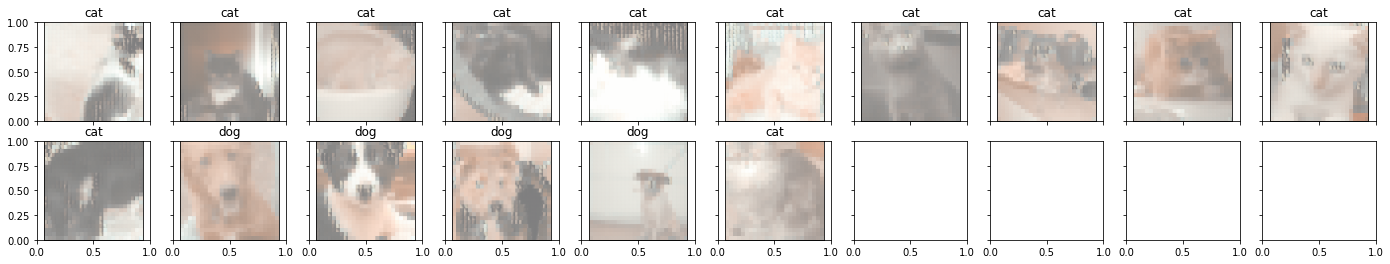

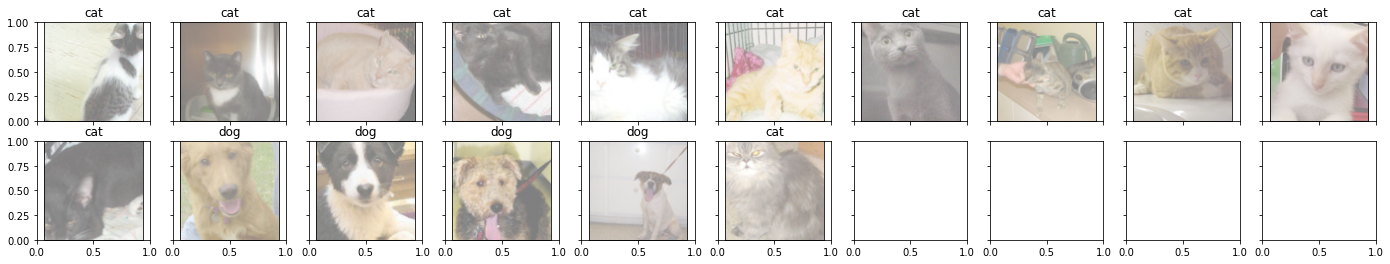

In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))


# obtain one batch of test images
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# output = F.softmax(output)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, size, size)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


Now, we loop through the training set and calculate reconstruction loss 

In [8]:
dataloaders['valid'] = DataLoader(data['valid'], batch_size=1, shuffle=True)
dataloaders['test'] = DataLoader(data['test'], batch_size=1, shuffle=True)

results = []
results_cols = ["Image Label", "Reconstruction Loss"]
for x, y in dataloaders['valid']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        # ls = model.criterion(output, image)
        results.append([label, ls])

results = pd.DataFrame(results, columns=results_cols)
results.to_csv("reconstruction_error.csv")


#find error threshold on validation set



#evaluate on testing data

     Image Label  Reconstruction Loss
0              1           294.592316
1              1            46.137787
2              1            63.591209
3              1           313.671021
4              0           692.638916
...          ...                  ...
2123           1           167.537842
2124           1           192.467163
2125           1            97.057259
2126           0           156.166443
2127           1           366.591217

[2128 rows x 2 columns]
     Image Label  Reconstruction Loss
4              0           692.638916
5              0           549.416931
6              0           186.208786
9              0           228.896118
12             0           172.973099
...          ...                  ...
2110           0           297.112518
2113           0           227.112411
2119           0           524.869141
2122           0           614.925903
2126           0           156.166443

[614 rows x 2 columns]
     Image Label  Reconstruction Loss
0

Text(0, 0.5, 'Frequency')

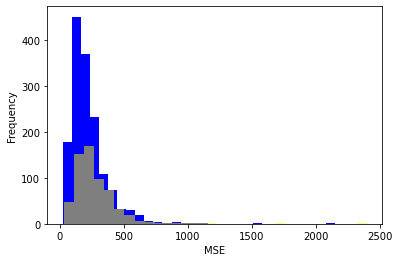

In [9]:
print(results)
label_1 = results[results["Image Label"] == 1]
label_0 = results[results["Image Label"] == 0]
print(label_0)
print(label_1)
avg_1 = np.mean(label_1['Reconstruction Loss'].values)
avg_0 = np.mean(label_0['Reconstruction Loss'].values)

print("Average Reconstruction Error (Prediction = 0)", avg_0)
print("Average Reconstruction Error (Prediction = 1)", avg_1)

plt.hist(label_1['Reconstruction Loss'].values, density=False, bins=30, color='blue')
plt.hist(label_0['Reconstruction Loss'].values, density=False, bins=30, alpha = 0.5,color='yellow')
plt.xlabel('MSE')
plt.ylabel('Frequency')


In [ ]:
threshold = 750
y_true = []
y_pred = []
for x, y in dataloaders['test']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        y_true.append(label)
        if ls >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

print(y_true)
print(y_pred)

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Accuracy: ", accuracy)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-Score: ", f1)
print("Confusion Matrix: ", cm)